# Structural methods aimed to price non-standard debts
ZSAMC_RI

XU YIFEI


## Background
This is a method practice aimed to solve ZSAMC private credit pricing problems. In the past ten years ZSAMC has experienced fast growth and asset inflation, however, more and more professionals in the company believe that the favorable external environment has gone. Here let the notebook makes the problem more clear. In the past fast growth period, China economy dynamic exhibits festures like rising property price, tightening financial industry regulation, depressing ex&import and related manufactory. Under such circustance, property developers has high capital demond but restricted supply. On the other hand, commercial banks eager to reach loan development target, with deflated manufactory asset value and inflated property asset value. 

Benefited by such a structual conflict between commerical demand and regulatory target, ZSAMC finds it place between banks and property developers, and develops private credit business line. Similar story also happens in banks and non-performing-asset secondary participants, ZSAMC call that version of credit asset as cpL term loan. Unfortunately, the external environment becomes unfavorable, thus ZSAMC has to shrink its profit margin. This notebook is aimed to find and draw the red line on the profit margin to protect stakeholders against volatile asset value.

## Logistic
### Reason why traditional analysis technique is not appliable
Traditional credit risk analysis methodology starts with mapping features to default(0/1) or loss rate. Unfortunately, the PRIVATE credit ledger gives little useful information about the feature or target(PD and LGD). Further methodologies like logistic regression, beta regression, balanced scorecard is not appliable.
The private credit business treat underlying asset as first redemption source because the the borrower is in financial distress or just kind of server. Since this notebook has to focus on underlying asset value, structual model is an appliable path.

### Structural approach 
Inspired by Merton model, especially risk quantification article by Yu Wang, this method practice belives that credit spread problem can be converted to derivative pricing problem, and moreover, various stochastic differential equtation simulations. The combined payoff of a risky bond and put option equals risk free bond, in other words, risky bond can be treated as synthetics of risk free bond and put option. The valuation of risk free bond is straightforward, then the credit spread pricing problem becomes a derivative pricing problem.

### Conversion
Based on vanilla accounting common sense, equity and debt constitute the capital source and return distribution of any asset, at any time, like:
$$
A_{t} = D_{t} + E_{t}
$$

At the end of asset holding period, the value of debt and equity depends on the realized asset value, given by market or transaction counterparty. If the realized asset value is equal or less than promised debt principal, the equity holders get nothing. On the other hand, if the realized asset value is greater than promised debt principal, the equity holders receive everything exceeds debt principal. The payoff of equity holder can be expressed as such:
$$
E_{T} = max(A_{T} - K, 0)
$$
Here K expresses the debt principal

The payoff of equity holder is equivalent to call option, similarly debt holder payoff also can be expressed as synthetics. Debt holder receives principal if the realized asset value exceeds principal, and receives realized asset value if not.The payoff of debt holder can be expressed as such:
$$
D_{T} = min(A_{T}, K)
$$
Transform the above formula,
$$
D_{T} = min(A_{T} - K, 0) + K
$$
Further,
$$
D_{T} = - max(K - A_{T}, 0) + K
$$
Here payoff of debt holder can be expressed as risk free fixed income plus a short position in put option. Now it is safe to say, the valuation of risky debt can be treated as some sort of valuation of derivative. 
$$\begin{aligned}
D_T e^{-r(T-t)} &= (- max(K - A_{(T-t)}, 0) + K) e^{-r(T-t)} \\
D_t &= -P_t + Ke^{-r(T-t)}\\
&= Ke^{-(r+s)(T-t)}\\
\end{aligned}$$
Thus risky debt spread can be expressed as,
$$
s = -\frac{1}{T-t} \ln[-\frac{P_t}{K} e^{T-t} + 1]
$$

## Data
To implement the structural model, fair priced put price should be provided, for the purpose of parameter calibration. Obviously no immediately data is available, thus the fair priced put price is calculated from instant bid-ask or historical replication. Instant bid-ask spread can be used to replicate the implied put option price, for further option price model calibration. While historical cash flow can be used to calculate real debt value and spread, which can be much deviated from contractual spread. The key problem is, the instant bid-ask spread is real time and forward-looking priced, but the holding period and contractual price is not reliable. The historical replicated holding period and spread is solid, but out of instant pricing environment. In the latter model implemention, two data source would be implemented and compared.

## Methodology
The asset realized value goes randomly in real world, with drift and diffusion influence in every slice of time period. The drift can be constant or mean-reverting, depending on which side the asset is. For interest rate quote, the drift is mean-reverting because the basic responsibility of central bank is to maintain financial stability. For equity and commodity, the drift can be constant positive because in the long term inflation drives price up. The diffusion part can be constant or stochastic also. Heston model and merton jump-diffusion are classical dual stochastic process.

More stochastic process characteristic function and relative derivation process, please refer to Explanation notebook.

## Import packages

In [30]:
import numpy as np
import scipy.stats as si
from scipy.integrate import quad
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy import interpolate
import cmath
from scipy.fft import fft


## Data preprocessing
Based on the asset control department worksheet, fixed income asset includes term loan on assets (收购/处置分期) and term loan on entities(投行业务). Few useful features can be found from the worksheet, if take the sheet "处置分期" as example, the operation department, responsible manager, asset code cannot be treated as features, because the distribution of business oppotunities is random, and the responsible manager is in charge of the purchase and dispose of the asset, which means ZSAMC cannot treat responsible manager as a factor. The year of purchase can be treated as feature, because the year of purchase represents the macroeconomy status and risk intake. Within/out province is a feature, because in or out reach of HQ management can alter the ZSAMC's ability to handle after-risk issues, which, in backwards, affects the risk premium ZSAMC requires. Contract principal is the underlying asset initial value, or S0. The term loan on assets is the strike price, or K. The length of contract is option exercise period, or T. The risk premium can be translated into put option price by merton model.

In [31]:
# here, the underlying asset value has been standardalized to 100.
#excel_file = 'fixed income pricing/vanilla.xlsx' # on jupyter notebook
excel_file = 'F:/我的坚果云/浙商资产/固定收益定价/vanilla.xlsx' # on my window
#excel_file = '/Users/nannan/Nutstore Files/Nutstore/浙商资产/固定收益定价/vanilla.xlsx' # on my mac
df = pd.read_excel(excel_file, sheet_name='Sheet2')
print(df)

            code ticker  intake year counter party            S0          K  \
0            NaN   处置分期         2014          债务和解   1600.000000   1400.000   
1            NaN   处置分期         2015          债权转让    185.000000    135.000   
2            NaN   处置分期         2015          债权转让   1000.000000    700.000   
3            NaN   处置分期         2015          债权转让   2646.000000   2046.000   
4            NaN   处置分期         2016          债权转让   1500.000000   1200.000   
...          ...    ...          ...           ...           ...        ...   
1627  BW42406072   收购配资         2024          债权转让   9100.466667   6700.000   
1628  BW42406071   收购配资         2024          债权转让  36210.000000  26911.272   
1629  BW42406052   收购配资         2024          债权转让   3300.000000   2200.000   
1630  BW42406051   收购配资         2024          债权转让  14660.000000  10160.000   
1631  BW42406252   收购配资         2024          债权转让   3810.000000   2667.000   

               start time             end time inte

                        date  simulated rate  internal risk free rate
term                                                                 
91.25    2024-11-08 06:00:00        1.554407                 1.554407
182.50   2025-02-07 12:00:00        1.604523                 1.604523
273.75   2025-05-09 18:00:00        1.574797                 1.574797
365.00   2025-08-09 00:00:00        1.545072                 1.545072
456.25   2025-11-08 06:00:00        1.569260                 1.569260
...                      ...             ...                      ...
10585.00 2053-08-02 00:00:00        2.291877                 2.291877
10676.25 2053-11-01 06:00:00        2.292520                 2.292520
10767.50 2054-01-31 12:00:00        2.293162                 2.293162
10858.75 2054-05-02 18:00:00        2.293805                 2.293805
10950.00 2054-08-02 00:00:00        2.294447                 2.294447

[120 rows x 3 columns]


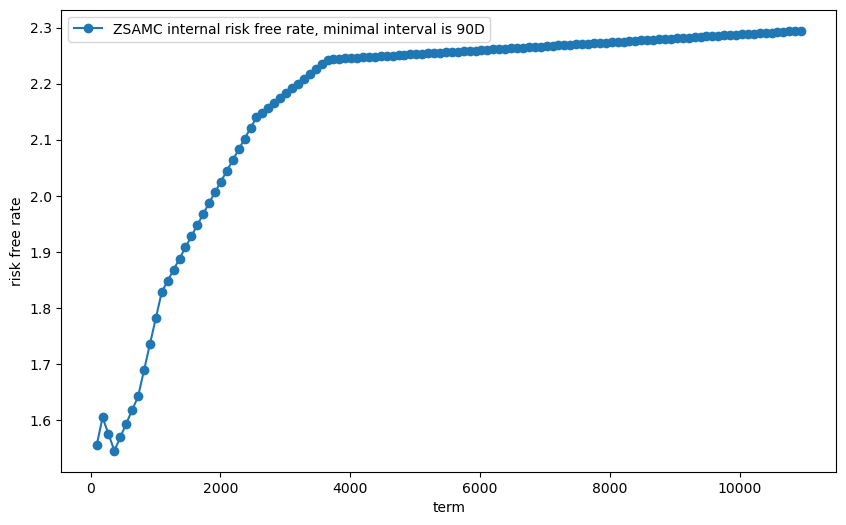

In [32]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
# read risk free rate
#rf_excel_file = '/Users/nannan/Nutstore Files/Nutstore/浙商资产/固定收益定价/output.xlsx' # on my mac
rf_excel_file = 'F:/我的坚果云/浙商资产/固定收益定价/output.xlsx' # on my window
rf_df = pd.read_excel(rf_excel_file)
rf_df = rf_df.loc[:, ~rf_df.columns.str.contains('^Unnamed')]
oberservation_date = '2024-8-9'
oberservation_date = datetime.strptime(oberservation_date, '%Y-%m-%d')
term_list = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 30]
term_list = [term*365 for term in term_list]
datetime_list = [oberservation_date + relativedelta(days=term) for term in term_list]
rf_df['date'] = datetime_list
rf_df['date'] = pd.to_datetime(rf_df['date'])
rf_df.set_index('date', inplace=True)
'''
plt.figure(figsize=(10, 6))
plt.plot(rf_df.index, rf_df['simulated rate'], label='simulated rate')
plt.title('risk free rate')
plt.xlabel('date')
plt.ylabel('risk free rate')
plt.grid(True)
plt.show()
'''
target_term_list = np.linspace(0.25, 30, 120)
target_term_list = [term*365 for term in target_term_list]
targeted_datetime_list = [oberservation_date + relativedelta(days=term) for term in target_term_list]
targeted_df = pd.DataFrame(targeted_datetime_list, columns=['date'])
targeted_df.set_index('date', inplace=True)

combined_df = rf_df.reindex(rf_df.index.union(targeted_df.index))
combined_df['simulated rate'] = combined_df['simulated rate'].interpolate(method='linear')

interpolated_df = combined_df.loc[targeted_datetime_list]
interpolated_df.reset_index(inplace=True)
interpolated_df['term'] = target_term_list
interpolated_df.set_index('term', inplace=True)
ZSAMC_gov_spread = 0 # sponsored by capital management department
ZSAMC_fixed_cost = 0 # sponsored by financial management department
ZSAMC_shareholder_modest_return = 0 # sponsored by shareholder
interpolated_df['internal risk free rate'] = interpolated_df['simulated rate'] + ZSAMC_gov_spread + ZSAMC_fixed_cost + ZSAMC_shareholder_modest_return
print(interpolated_df)

# Plot the interpolated risk-free rate data
plt.figure(figsize=(10, 6))
plt.plot(interpolated_df.index, interpolated_df['internal risk free rate'], marker='o', linestyle='-', label='ZSAMC internal risk free rate, minimal interval is 90D')
plt.xlabel('term')
plt.ylabel('risk free rate')
plt.legend()
plt.show()



In [33]:
# preprocess raw data
df = df.dropna(axis=1, how='all')
df = df[df['S0']>=df['K']]
df['per_K'] = df['K']/df['S0']*100
df['start time'] = pd.to_datetime(df['start time'], errors='coerce')
df['end time'] = pd.to_datetime(df['end time'], errors='coerce')
df['Maturity_days'] = (df['end time']-df['start time']).dt.days
df = df[df['Maturity_days']>0]
df['Maturity_years'] = df['Maturity_days']/365
df['management fee'] = df['management fee'].fillna(0.0)
df['interest rate'] = df['interest rate'].fillna(0.0)
df = df[~df['interest rate'].apply(lambda x: isinstance(x, str))]
df = df[~df['management fee'].apply(lambda x: isinstance(x, str))]
df['yield'] = df['interest rate'] + df['management fee']/df['Maturity_years']
df = df[df['start time']>=pd.Timestamp('2024-01-01')]
df = df[df['interest rate'] >= 0.08]
print(df)

            code ticker  intake year counter party            S0          K  \
668   BC32401051   处置分期         2023          债权转让    678.000000    474.600   
670   BC32401082   处置分期         2024          债权转让    690.000000    400.000   
671   BC32401081   处置分期         2024          债权转让    580.000000    406.000   
672   BC32401053   处置分期         2024          债权转让   4200.000000   2940.000   
673   BC32401052   处置分期         2024          债权转让   5520.000000   3864.000   
...          ...    ...          ...           ...           ...        ...   
1627  BW42406072   收购配资         2024          债权转让   9100.466667   6700.000   
1628  BW42406071   收购配资         2024          债权转让  36210.000000  26911.272   
1629  BW42406052   收购配资         2024          债权转让   3300.000000   2200.000   
1630  BW42406051   收购配资         2024          债权转让  14660.000000  10160.000   
1631  BW42406252   收购配资         2024          债权转让   3810.000000   2667.000   

     start time   end time interest rate management

In [34]:
# need further filter here, interest rate and term should have a positive correlation


In [35]:
# the above interest is coupon rate, which is not discount rate. to find the proper credit spread, the notebook needs to find
# discount rate by trying newton method
# the queston is, the maturity is irregular, thus the notebook treat the it as zero coupon risky corporate bond.
# if there is any regular payment, below code should be used.
'''
def calculate_discount_rate(coupon, maturity, principal):
    # Define the present value equation
    def present_value(rate):
        pv = 0
        for t in range(1, maturity + 1):
            pv += coupon / ((1 + rate) ** t)
        pv += principal / ((1 + rate) ** maturity)
        return pv

    # Use numerical optimization to find the discount rate
    from scipy.optimize import newton
    discount_rate = newton(lambda r: present_value(r) - principal, 0.05)
    return discount_rate
df['discount_rate'] = df.apply(lambda row: calculate_discount_rate(df['interest'], df['Maturity_days'], df['Strike']), axis=1)
'''

"\ndef calculate_discount_rate(coupon, maturity, principal):\n    # Define the present value equation\n    def present_value(rate):\n        pv = 0\n        for t in range(1, maturity + 1):\n            pv += coupon / ((1 + rate) ** t)\n        pv += principal / ((1 + rate) ** maturity)\n        return pv\n\n    # Use numerical optimization to find the discount rate\n    from scipy.optimize import newton\n    discount_rate = newton(lambda r: present_value(r) - principal, 0.05)\n    return discount_rate\ndf['discount_rate'] = df.apply(lambda row: calculate_discount_rate(df['interest'], df['Maturity_days'], df['Strike']), axis=1)\n"

In [36]:
# Use a lambda function with apply to calculate a new column
df['call'] = df.apply(lambda row: 100-row['per_K']*np.exp(-row['yield']*row['Maturity_years']), axis=1) 
df['call'] = pd.to_numeric(df['call'], errors='coerce')
term_loan_df = df[df['ticker'] == '收购配资']
term_loan2_df = df[df['ticker'] == '处置分期']
def group_df(df, column_name):
    # Create bins for 'Strike' values and 'Maturity_days' values
    # define the upper and lower bound of normal asset strike and maturity
    df['strike_bins'] = pd.cut(df['per_K'], bins=range(45, 80, 10), right=True)
    df['maturity_bins'] = pd.cut(df['Maturity_days'], bins=np.arange(182.5, 1095, 365), right=True)
    
    '''
    # part of bins has too few data, thus remove them
    df['bins'] =list(zip(df['strike_bins'], df['maturity_bins']))
    def remove_outliers(group):
        z_scores = zscore(group['call'])
        return group[(z_scores > -3) & (z_scores < 3)]
    df = df.groupby('bins').apply(remove_outliers).reset_index(drop=True)
    '''

    # Calculate the average 'call' values
    df_regroup = df.groupby(['strike_bins', 'maturity_bins'])[column_name].mean()

    # Create a new dataframe with the calculated averages
    df_regroup = df_regroup.reset_index()
    df_regroup[column_name] = df_regroup[column_name].interpolate()
    df_regroup.fillna(method='ffill', inplace=True)
    
    # Replace the 'strike_bins' and 'maturity_bins' with their mean values
    df_regroup['Strike'] = df_regroup['strike_bins'].apply(lambda x: x.mid)
    df_regroup['Maturity_days'] = df_regroup['maturity_bins'].apply(lambda x: x.mid)
    return df_regroup

print(group_df(df, 'call'))
print(group_df(df, 'yield'))

  strike_bins   maturity_bins       call Strike Maturity_days
0    (45, 55]  (182.5, 547.5]  54.586657   50.0         365.0
1    (45, 55]  (547.5, 912.5]  57.459899   50.0         730.0
2    (55, 65]  (182.5, 547.5]  45.938858   60.0         365.0
3    (55, 65]  (547.5, 912.5]  50.881251   60.0         730.0
4    (65, 75]  (182.5, 547.5]  37.021931   70.0         365.0
5    (65, 75]  (547.5, 912.5]  43.358915   70.0         730.0
  strike_bins   maturity_bins     yield Strike Maturity_days
0    (45, 55]  (182.5, 547.5]  0.099103   50.0         365.0
1    (45, 55]  (547.5, 912.5]  0.101585   50.0         730.0
2    (55, 65]  (182.5, 547.5]  0.099870   60.0         365.0
3    (55, 65]  (547.5, 912.5]  0.106784   60.0         730.0
4    (65, 75]  (182.5, 547.5]  0.102924   70.0         365.0
5    (65, 75]  (547.5, 912.5]  0.105456   70.0         730.0


In [37]:
def read_df(df, column_name):
    strikes = np.sort(df.Strike.unique())
    maturities = np.sort(df.Maturity_days.unique())
    X, Y = np.meshgrid(strikes, maturities)
    output = np.empty((len(maturities), len(strikes)))
    # for any given maturity
    for i in range(len(maturities)):
        # extract strike under given maturity
        s = df[df.Maturity_days == maturities[i]]['Strike']
        # and call option price
        output_content = df[df.Maturity_days == maturities[i]][column_name]
        f = interpolate.interp1d(s, output_content, kind='linear', bounds_error=False, fill_value="extrapolate")
        output[i, :] = f(strikes)

    return strikes, maturities, output

In [38]:
strikes, maturities, call_price = read_df(group_df(df, 'call'), 'call')
print(strikes)
print(maturities)
print(call_price)

[50. 60. 70.]
[365. 730.]
[[54.58665698 45.93885823 37.02193102]
 [57.45989938 50.88125077 43.35891522]]


In [39]:
strikes, maturities, real_yield = read_df(group_df(df, 'yield'), 'yield')
real_yield_df = pd.DataFrame(real_yield, index=maturities, columns=strikes)
print(real_yield_df)

           50.0      60.0      70.0
365.0  0.099103  0.099870  0.102924
730.0  0.101585  0.106784  0.105456


## Plot surface

In [40]:
# calculate implied volatility in order to select appropriate stochastic process
# calculate bs volatility surface
# newton raphson method
import math
from scipy.stats import norm

def black_scholes_call(S, X, r, t, sigma):
    d1 = (math.log(S / X) + (r + 0.5 * sigma ** 2) * t) / (sigma * math.sqrt(t))
    d2 = d1 - sigma * math.sqrt(t)
    C = S * norm.cdf(d1) - X * math.exp(-r * t) * norm.cdf(d2)
    return C

def calculate_implied_volatility_bisection(S, X, r, t, option_price, tolerance, max_iterations):
    lower_vol = 0.0001
    upper_vol = 5.0
    for i in range(max_iterations):
        mid_vol = (lower_vol + upper_vol) / 2
        option_price_calculated = black_scholes_call(S, X, r, t, mid_vol)
        error = option_price_calculated - option_price
        if abs(error) < tolerance:
            return mid_vol
        if option_price_calculated < option_price:
            lower_vol = mid_vol
        else:
            upper_vol = mid_vol
    return mid_vol

# Set the option parameters
S = 100  # Current price of the underlying asset
r = 0.065  # Risk-free interest rate
initial_guess = 2  # Initial guess for implied volatility
tolerance = 0.0001  # Tolerance for the error
max_iterations = 10  # Maximum number of iterations
maturity_years = maturities/365

implied_vol = np.empty((len(maturities), len(strikes)))
for i in range(len(maturities)):
    for j in range(len(strikes)):
        implied_vol[i][j] = calculate_implied_volatility_bisection(S, strikes[j], r, maturity_years[i], call_price[i][j], tolerance, max_iterations)
print(implied_vol)
'''
# replace negative implied volatility by nearest non-negative value
for i in range(len(implied_vol)):
    for j in range(len(implied_vol[i])):
        if implied_vol[i][j] < 0:
            # Find the nearest non-negative volatility
            nearest_non_negative_volatility = next((x for x in implied_vol[i][j:] if x >= 0), implied_vol[i][j-1])
            implied_vol[i][j] = nearest_non_negative_volatility

# replace implied volatility greater than 2 by nearest reasonable value
for i in range(len(implied_vol)):
    for j in range(len(implied_vol[i])):
        if implied_vol[i][j] > 2:
            # Find the nearest implied volatility that is less than or equal to 2
            valid_volatility = [x for x in implied_vol[i] if x <= 2]
            if valid_volatility:
                nearest_volatility = min((x for x in implied_vol[i] if x <= 2), key=lambda x: abs(x - implied_vol[i][j]))
                implied_vol[i][j] = nearest_volatility
            else:
                implied_vol[i][j] = 2

# Print the modified implied_vol array
print(implied_vol)
adjusted_call_price = np.empty((len(maturities), len(strikes)))
for i in range(len(maturities)):
    for j in range(len(strikes)):
        adjusted_call_price[i][j] = black_scholes_call(S, strikes[j], r, maturity_years[i], implied_vol[i][j])

print(adjusted_call_price)

'''

[[0.55184678 0.4932542  0.41513076]
 [0.41513076 0.44442705 0.40536533]]


'\n# replace negative implied volatility by nearest non-negative value\nfor i in range(len(implied_vol)):\n    for j in range(len(implied_vol[i])):\n        if implied_vol[i][j] < 0:\n            # Find the nearest non-negative volatility\n            nearest_non_negative_volatility = next((x for x in implied_vol[i][j:] if x >= 0), implied_vol[i][j-1])\n            implied_vol[i][j] = nearest_non_negative_volatility\n\n# replace implied volatility greater than 2 by nearest reasonable value\nfor i in range(len(implied_vol)):\n    for j in range(len(implied_vol[i])):\n        if implied_vol[i][j] > 2:\n            # Find the nearest implied volatility that is less than or equal to 2\n            valid_volatility = [x for x in implied_vol[i] if x <= 2]\n            if valid_volatility:\n                nearest_volatility = min((x for x in implied_vol[i] if x <= 2), key=lambda x: abs(x - implied_vol[i][j]))\n                implied_vol[i][j] = nearest_volatility\n            else:\n       

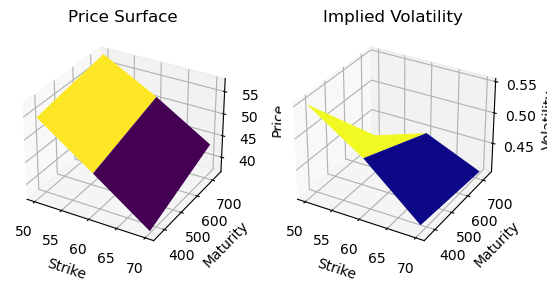

In [41]:
# By plotting price surface or volatility surface, decide which kind of stochastic process to use
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Create 3D grid
X, Y = np.meshgrid(strikes, maturities)

# Plotting
price_surface = ax1.plot_surface(X, Y, call_price, cmap='viridis')
# Customize the plot
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')
ax1.set_title('Price Surface')
vol_surface = ax2.plot_surface(X, Y, implied_vol, cmap='plasma')
# Customize the plot
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Volatility')
ax2.set_title('Implied Volatility')
plt.show()

## Calculation modules
Original price surface and implied volatility surface is quite weird, especially the negative volatility and peak volatility, which implied market anomaly. To fit the unexpected implied volatility surface, classic BS model cannot be applied, stochastic volatility process like Heston model or Bates model may work. The above implied volatility surface replaces the negative volatility with nearest non-negative volatility.

In [42]:
# find risk free rate corresponding to each maturity
def find_rf_rate(maturity):
    maturity_days = maturity*365
    return interpolated_df.loc[maturity_days, 'internal risk free rate']/100

In [43]:
def call_to_put(call, S0, K, r, T):
    put = call+np.exp(-r*T)*K-S0
    return put

In [44]:
def put_to_spread(put, r, K, T):
    s = -1/T*np.log(-put/K*np.exp(r*T)+1)
    return s

In [45]:
def put_to_yield(put, r, K, T):
    debt_required_return = -1/T*np.log(-put/K+np.exp(-r*T))
    return debt_required_return

In [46]:
# Define a safe exponential function
def safe_exp(x):
    # Define a maximum value for the exponent to prevent overflow
    max_exp = 700  # This is a safe value for most practical purposes
    return np.exp(np.clip(x, -max_exp, max_exp))

In [47]:
# based on original Heston paper
def Heston_characteristic_function(u, params, r, T, S0):
    kappa = params[0]
    theta = params[1]
    sigma = params[2]
    rho = params[3]
    v0 = params[4]
    xi = kappa - sigma*rho*u*1j
    d = np.sqrt((rho*sigma*u*1j - xi)**2 - sigma**2 * (-u*1j - u**2))
    g = (xi - rho*sigma*u*1j - d) / (xi - rho*sigma*u*1j + d)
    C = r*u*1j*T + (kappa*theta) / sigma**2 * ((xi - rho*sigma*u*1j - d)*T - 2*np.log((1 - g*np.exp(-d*T)) / (1 - g)))
    D = (xi - rho*sigma*u*1j - d) / sigma**2 * ((1 - np.exp(-d*T)) / (1 - g*np.exp(-d*T)))
    return np.exp(C + D*v0 + 1j*u*np.log(S0))

In [48]:
# Bates’ Approach(2006) 
def Bates_Heston_call_price(params, S0, K, r, T):
    integrand = lambda u: (np.exp(-1j*u*np.log(K)) * Heston_characteristic_function(u, params, r, T, S0) / (1j*u*(1-1j*u))).real
    integral_result, _ = quad(integrand, 0, np.inf, epsabs=1.0e-10, epsrel=1.0e-10)
    return S0 - K*np.exp(-r*T)*(1/2+integral_result/np.pi)

In [49]:
# Carr and Madan Approach（1999）
# from: Option Pricing Formulae using Fourier Transform: Theory and Application, Martin Schmelzle, p23, formula 4.37 
def Carr_Heston_call_price(alpha, params, S0, K, r, T):
    integrand = lambda u: (np.exp(-1j*u*np.log(K))*np.exp(-r*T)*Heston_characteristic_function(u-(alpha+1)*1j, params, r, T, S0)/(alpha**2+alpha-u**2+1j*(2*alpha+1)*u)).real
    integral_result, _ = quad(integrand, 0, np.inf, epsabs=1.0e-10, epsrel=1.0e-10)
    return (np.exp(-alpha*np.log(K))/np.pi)*integral_result

In [50]:
def Bates_characteristic_function(u, params, r, T, S0):
    kappa, theta, sigma, rho, v0, mu_J, sigma_J, lamda = params
    d = np.sqrt((rho * sigma * 1j * u - kappa)**2 + (u**2 + 1j * u) * sigma**2)
    g = (kappa - rho * sigma * 1j * u - d) / (kappa - rho * sigma * 1j * u + d)
    
    # Avoid numerical instability by clamping the exponent
    max_exp = 700
    C = r * 1j * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * 1j * u - d) * T - 2 * np.log(np.clip((1 - g * np.exp(-d * T)) / (1 - g), -max_exp, max_exp)))
    D = ((kappa - rho * sigma * 1j * u - d) / sigma**2) * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
    
    # Handle jump component
    jump_component = lamda * T * (np.exp(1j * u * mu_J - 0.5 * sigma_J**2 * u**2) - 1)
    
    return np.exp(C + D * v0 + 1j * u * np.log(S0) + jump_component)

In [51]:
def sabr_characteristic_function(u, params, r, T, S0):
    sigma, beta, rho, v0 = params
    i = 1j
    z = (v0 / sigma) * (S0**(1 - beta)) * np.log(S0)
    x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
    phi = np.exp(i * u * np.log(S0) + (sigma**2 / (2 * v0**2)) * ((1 - np.exp(-v0 * T)) / (1 - rho * np.exp(-v0 * T))) * (1 - np.exp(-v0 * T)))
    return phi

In [52]:
# Generic FFT, Bates’ Approach(2006) and Carr and Madan Approach（1999） can be implemented by this function
def genetic_FFT(params, S0, K, r, T, alpha, eta, n, model_type):
    N = 2**n
    lamda = (2*np.pi/N) / eta
    beta = np.log(K)
    k = np.zeros((N))
    x = np.zeros((N))
    discount_factor = np.exp(-r*T)
    nu_J = np.arange(N)*eta
    if model_type == 'Bates':
        psi_nu_J = Bates_characteristic_function(nu_J - (alpha+1)*1j, params, r, T, S0) / ((alpha + 1j*nu_J)* (alpha + 1 + 1j*nu_J)) # Bates’ Approach(2006)
    elif model_type == 'Heston':
        psi_nu_J = Heston_characteristic_function(nu_J - (alpha+1)*1j, params, r, T, S0) / ((alpha + 1j*nu_J)* (alpha + 1 + 1j*nu_J)) # Carr and Madan Approach（1999）
    elif model_type == 'SABR':
        psi_nu_J = sabr_characteristic_function(nu_J - (alpha+1)*1j, params, r, T, S0) / ((alpha + 1j*nu_J)* (alpha + 1 + 1j*nu_J)) # Hagan (2002)
    
    
    for j in range(N):
        k[j] = beta + j*lamda
        if j == 0:
            w_J = (eta/2)
        else:
            w_J = eta
        x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J
    y = fft(x)
    fft_model_price = np.zeros((N))
    for i in range(N):
        multiplier = np.exp(-alpha*k[i])/np.pi
        fft_model_price[i] = multiplier*np.real(y[i])
    return fft_model_price[0]

In [53]:
# Bates and Scott model characteristic function, Heston model plus jump
# from: Calibration of stochastic volatility models, Yavor Kovachev, p5, formula 2.7
'''
def Bates_characteristic_function(u, params, r, T, S0):
    kappa = params[0]
    theta = params[1]
    sigma = params[2]
    rho = params[3]
    v0 = params[4]
    mu_J = params[5]
    sigma_J = params[6]
    lamda = params[7]
    d = np.sqrt((rho*sigma*1j*u-kappa)**2+(sigma**2)*(1j*u+u**2))
    g = (kappa-rho*sigma*u*1j-d)/(kappa-rho*sigma*u*1j+d)
    A = 1j*u*np.log(S0)+1j*u*r*T
    B = ((theta*kappa)/(sigma**2))*((kappa-rho*sigma*1j*u-d)*T-2*np.log((1-g*np.exp(-d*T))/(1-g)))
    C = ((v0/(sigma**2))*(kappa-rho*sigma*1j*u-d)*(1-np.exp(-d*T)))/(1-g*np.exp(-d*T))
    D = -lamda*mu_J*1j*u*T+lamda*T*(((1+mu_J)**(1j*u))*np.exp(1/2*(sigma_J**2)*1j*u*(1j*u-1))-1)
    return np.exp(A+B+C+D)
'''

'\ndef Bates_characteristic_function(u, params, r, T, S0):\n    kappa = params[0]\n    theta = params[1]\n    sigma = params[2]\n    rho = params[3]\n    v0 = params[4]\n    mu_J = params[5]\n    sigma_J = params[6]\n    lamda = params[7]\n    d = np.sqrt((rho*sigma*1j*u-kappa)**2+(sigma**2)*(1j*u+u**2))\n    g = (kappa-rho*sigma*u*1j-d)/(kappa-rho*sigma*u*1j+d)\n    A = 1j*u*np.log(S0)+1j*u*r*T\n    B = ((theta*kappa)/(sigma**2))*((kappa-rho*sigma*1j*u-d)*T-2*np.log((1-g*np.exp(-d*T))/(1-g)))\n    C = ((v0/(sigma**2))*(kappa-rho*sigma*1j*u-d)*(1-np.exp(-d*T)))/(1-g*np.exp(-d*T))\n    D = -lamda*mu_J*1j*u*T+lamda*T*(((1+mu_J)**(1j*u))*np.exp(1/2*(sigma_J**2)*1j*u*(1j*u-1))-1)\n    return np.exp(A+B+C+D)\n'

In [54]:
# direct integration of bates model
def Bates_call_price(params, S0, K, r, T):
    kappa = params[0]
    theta = params[1]
    sigma = params[2]
    rho = params[3]
    v0 = params[4]
    mu_J = params[5]
    sigma_J = params[6]
    lamda = params[7]
    integrand_1 = lambda u: ((np.exp(-1j*u*np.log(K))*Bates_characteristic_function(u-1j, params, r, T, S0))/(1j*u*Bates_characteristic_function(-1j, params, r, T, S0))).real
    integral_result_1, _ = quad(integrand_1, 0, np.inf, epsabs=1.0e-10, epsrel=1.0e-10)
    integrand_2 = lambda u: ((np.exp(-1j*u*np.log(K))*Bates_characteristic_function(u, params, r, T, S0))/(1j*u)).real
    integral_result_2, _ = quad(integrand_2, 0, np.inf, epsabs=1.0e-10, epsrel=1.0e-10)
    return S0*(1/2+1/np.pi*integral_result_1)-K*np.exp(-r*T)*(1/2+1/np.pi*integral_result_2)

In [55]:
# examine the calculation modules, till here model price is available
# below is optimization target parameters

kappa = 2.3 # speed of mean-reverting
theta = 0.046 # long term mean volatility
sigma = 0.0825 # volatility of volatility
rho = -0.53 # price return and volatility Brownian motions correlation
v0 = 0.054 # initial volatility
params_H = (kappa, theta, sigma, rho, v0) # Heston model parameters 

mu_J = -0.1 # muJ affects the skewness of distribution of price returns jump
sigma_J = 0.1 # sigma_J affects the kurtosis of distribution of price returns jump
lamda = 0.1 # Posson jump intense
params_B = (kappa, theta, sigma, rho, v0, mu_J, sigma_J, lamda) # Bates model parameters

beta = 0.5 # Elasticity of variance
params_S = (sigma, beta, rho, v0) # SABR model parameters

# below is stationary parameters
S0 = 100
K = 80
T = 2
r = find_rf_rate(T)
print(r)
alpha = 1
eta = 0.2
n = 10
print(r)

# Trail
call = genetic_FFT(params_H, S0, K, r, T, alpha, eta, n, 'Heston')
print(call)
put = call_to_put(call, S0, K, r, T)
print(put)
pv_risky_bond = -put+K*np.exp(-r*T)
print("Implied present value of risky debt is: {}".format(pv_risky_bond))
spread = put_to_spread(put, r, K, T)
print("Corresponding credit spread is: {}, yield should be: {}".format(spread, spread+r))
print(put_to_yield(put, r, K, T))


0.01641822106933709
0.01641822106933709
25.89581070698896
3.311556392484192
Implied present value of risky debt is: 74.10418929301103
Corresponding credit spread is: 0.021859063081540828, yield should be: 0.038277284150877916
0.03827728415087797


C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J


## Calibration module

The calibration module can be broken down by two parts, the first part is non-descent algorithms which find the global second optimization, in order to avoid regional optimization, then the second part is stochastic gradient desecent.

In [56]:
# Define the loss function, loop through each maturity
# add params check to avoid negative price
def loss_function(params, *args):
    real_price = args[0]
    S0 = args[1]
    strikes = args[2]
    r = args[3]
    maturity_years = args[4]
    alpha = args[5]
    eta = args[6]
    n = args[7]
    model_type = args[8]

    # Define parameter bounds
    kappa_bounds = (0.0, 10.0)
    theta_bounds = (0.0, 10.0)
    sigma_bounds = (0.0, 10.0)
    rho_bounds = (-1.0, 1.0)
    v0_bounds = (0.0, 10.0)
    mu_J_bounds = (-10.0, 10.0)
    sigma_J_bounds = (0.0, 10.0)
    lamda_bounds = (0.0, 10.0)
    
# Unpack parameters based on the model type
    if model_type == 'Heston':
        kappa, theta, sigma, rho, v0 = params
        # Check if parameters are within bounds for the Heston model
        if not (sigma_bounds[0] <= sigma <= sigma_bounds[1] and
                kappa_bounds[0] <= kappa <= kappa_bounds[1] and
                theta_bounds[0] <= theta <= theta_bounds[1] and
                rho_bounds[0] <= rho <= rho_bounds[1] and
                v0_bounds[0] <= v0 <= v0_bounds[1]):
            return np.inf  # Return a large error if parameters are out of bounds
    elif model_type == 'Bates':
        kappa, theta, sigma, rho, v0, mu_J, sigma_J, lamda = params
        # Check if parameters are within bounds for the Bates model
        if not (sigma_bounds[0] <= sigma <= sigma_bounds[1] and
                kappa_bounds[0] <= kappa <= kappa_bounds[1] and
                theta_bounds[0] <= theta <= theta_bounds[1] and
                rho_bounds[0] <= rho <= rho_bounds[1] and
                v0_bounds[0] <= v0 <= v0_bounds[1] and
                mu_J_bounds[0] <= mu_J <= mu_J_bounds[1] and
                sigma_J_bounds[0] <= sigma_J <= sigma_J_bounds[1] and
                lamda_bounds[0] <= lamda <= lamda_bounds[1]):
            return np.inf  # Return a large error if parameters are out of bounds
    else:
        return np.inf  # Return a large error if model type is not recognized
    '''
    # Calculate the root mean squared error
    diff = real_price - genetic_FFT(params, S0, K, r, T, alpha, eta, n, model_type)
    squared_diff = diff ** 2
    rmse = np.sqrt(np.mean(squared_diff))
    print(genetic_FFT(params, S0, K, r, T, alpha, eta, n, model_type))
    '''
    loss_function_model_price = np.zeros((len(maturities), len(strikes)))
    count = 0
    mse = 0
    for i in range(len(maturities)):
        for j in range(len(strikes)):
            loss_function_model_price[i][j] = genetic_FFT(params, S0, strikes[j], r, maturity_years[i], alpha, eta, n, model_type)
            diff = real_price[i][j] - loss_function_model_price[i][j]
            mse += diff ** 2
            count += 1
    rmse = np.sqrt(mse / count)
    return rmse

In [57]:
# heston and bates model random parameters
num_arrays = 50000  # Specify the number of random arrays to generate
num_params = 8  # Specify the number of parameters in each array

# Define the ranges for each parameter, in a relative wide range
param_ranges = [
    (0.0, 1.0), # Range for kappa, speed of mean reverting
    (0.0, 1.0),  # Range for theta, level of long term volatility
    (0.0, 3.0),   # Range for sigma, volatility of volatility
    (-1.0, 0.0),  # Range for rho, correlation between the return brownian motion and volatility brownian motion
    (0.0, 1.0),  # Range for v0, initial volatility
    (-0.1, 0.1),   # Range for mu_J, expected jump size or magnitude
    (0.0, 1.0),       # Range for sigma_J, deviatation of jump size
    (0.0, 1.0)    # Range for lamda, jump intensity or frequency
]

# Generate the specified number of random arrays
direct_random_arrays_B = []
for _ in range(num_arrays):
    random_params = np.array([np.random.uniform(low, high) for low, high in param_ranges])
    direct_random_arrays_B.append(random_params)

direct_random_arrays_H = [arr[:5] for arr in direct_random_arrays_B]



In [58]:
model_type = 'Bates' # 'Heston' or 'Bates' or 'SABR'
rmse_min = 1e5
random_arrays = direct_random_arrays_B # random_arrays_B if goes to SVJ model
'''
# convert to cupy array
random_arrays = cp.array(random_arrays)
call_price = cp.array(call_price)
strikes = cp.array(strikes)
maturity_years = cp.array(maturity_years)
'''
for i in range(len(random_arrays)):
    rmse = loss_function(random_arrays[i], call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type)
    if rmse < rmse_min:
        rmse_min = rmse
        direct_search_params = random_arrays[i]
        print("RMSE: {}".format(rmse))
'''
# convert back to numpy array
rmse_min = cp.asnumpy(rmse_min)
direct_search_params = cp.asnumpy(direct_search_params)
'''  
print("Minimum RMSE: {} - Optimal Initial Parameters: {}".format(rmse_min, direct_search_params))


RMSE: 7.931614371920214
RMSE: 7.78379444366221
RMSE: 6.139927810098533
RMSE: 2.7614515192049454
RMSE: 1.8383523526517942
RMSE: 1.4087520434095968
RMSE: 1.24683495722673
RMSE: 1.0614632375267308
RMSE: 1.0583940212228036
RMSE: 0.9824812646955885
RMSE: 0.6305784957666406
RMSE: 0.6269127280304109
RMSE: 0.604493047432111
RMSE: 0.6036885307745102
RMSE: 0.5875759836550325
RMSE: 0.45884372491479536
RMSE: 0.43192583074998764
RMSE: 0.42520317514096845
Minimum RMSE: 0.42520317514096845 - Optimal Initial Parameters: [ 0.82984869  0.7926681   2.81299733 -0.99850987  0.1360639   0.05897197
  0.18633761  0.0175597 ]


C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J
C:\Users\student\AppData\Local\Temp\ipykernel_25240\3745630350.py:14: RuntimeWarning: overflow encountered in exp
  return np.exp(C + D * v0 + 1j * u * np.log(S0) + jump_component)
C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:11: RuntimeWarning: invalid value encountered in divide
  psi_nu_J = Bates_characteristic_function(nu_J - (alpha+1)*1j, params, r, T, S0) / ((alpha + 1j*nu_J)* (alpha + 1 + 1j*nu_J)) # Bates’ Approach(2006)
C:\Users\student\AppData\Local\Temp\ipykernel_25240\1092435759.py:62: RuntimeWarning: overflow encountered in scalar power
  mse += diff ** 2


In [59]:
print(direct_search_params)
T = 1
call = genetic_FFT(direct_search_params, S0, K, r, T, alpha, eta, n, model_type)
print(call)
put = call_to_put(call, S0, K, r, T)
print(put)
pv_risky_bond = -put+K*np.exp(-r*T)
print("Implied present value of risky debt is: {}".format(pv_risky_bond))
spread = put_to_spread(put, r, K, T)
print("Corresponding credit spread is: {}, yield should be: {}".format(spread, spread+r))

[ 0.82984869  0.7926681   2.81299733 -0.99850987  0.1360639   0.05897197
  0.18633761  0.0175597 ]
29.597795325592422
8.295061191946502
Implied present value of risky debt is: 70.40220467440757
Corresponding credit spread is: 0.1113838345330611, yield should be: 0.12780205560239818


C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J


## Genetic algorithm

Another way to find initial guess is to use genetic algorithm, which starts from range of parameters, and then uses crossover and mutatation to better suit the objective function(or call it cost function). The genetic algorithm perfects itself by multiple generations. Later the notebook would further refine the initial guess by stochastic gradient descent. Based on the trail, it is safe to say, genetic algorithm produce much preciser result than direct calibration.

In [60]:

# generate random parameters for genetic algorithm
import numpy as np

# Number of random arrays to generate
num_arrays = 2000

# Number of parameters in each array
num_params = 8
# Define the means for each parameter
param_means = direct_search_params

# Standard deviation for each parameter (you can adjust this as needed)
param_stddev = [
    0.05,  # Stddev for kappa
    0.05,  # Stddev for theta
    0.05,  # Stddev for sigma
    0.01,  # Stddev for rho
    0.05,  # Stddev for v0
    0.01,  # Stddev for mu_J
    0.01,  # Stddev for sigma_J
    0.01   # Stddev for lambda
]

# Generate the specified number of random arrays for the Bates model
genetic_random_arrays_B = []
for _ in range(num_arrays):
    random_params = np.array([np.random.normal(mean, stddev) for mean, stddev in zip(param_means, param_stddev)])
    genetic_random_arrays_B.append(random_params)

# Convert the list to a numpy array
genetic_random_arrays_B = np.array(genetic_random_arrays_B)

# Generate the specified number of random arrays for the Heston model
genetic_random_arrays_H = genetic_random_arrays_B[:, :5]

# Print the first few arrays to verify
print("First few random arrays for Bates model:")
print(genetic_random_arrays_B[:5])

print("\nFirst few random arrays for Heston model:")
print(genetic_random_arrays_H[:5])


First few random arrays for Bates model:
[[ 0.82761247  0.73800971  2.77128468 -1.00704106  0.12868089  0.04161935
   0.17134618  0.02233441]
 [ 0.76557442  0.80545083  2.78300473 -0.98456077  0.11668617  0.05250417
   0.17157851  0.03323009]
 [ 0.74912585  0.79808033  2.74742628 -1.00231432  0.14424784  0.06059108
   0.19748429  0.01948866]
 [ 0.82671052  0.84801101  2.87729345 -1.00649509  0.18396439  0.06222531
   0.16202321  0.02049945]
 [ 0.8194647   0.77720173  2.72789415 -1.01122634  0.19511131  0.06274532
   0.17837318  0.00722024]]

First few random arrays for Heston model:
[[ 0.82761247  0.73800971  2.77128468 -1.00704106  0.12868089]
 [ 0.76557442  0.80545083  2.78300473 -0.98456077  0.11668617]
 [ 0.74912585  0.79808033  2.74742628 -1.00231432  0.14424784]
 [ 0.82671052  0.84801101  2.87729345 -1.00649509  0.18396439]
 [ 0.8194647   0.77720173  2.72789415 -1.01122634  0.19511131]]


In [61]:

import numpy as np
from scipy.stats import norm
import math
import random
# Genetic algorithm optimization
def genetic_algorithm_optimization(call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type):
    population_size = num_arrays
    num_generations = 25
    mutation_rate = 0.001

    # Initialize the population with random parameter values
    population = genetic_random_arrays_B

    for generation in range(num_generations):
        # Evaluate the fitness of each individual in the population
        fitness_scores = list(map(lambda params: loss_function(params, call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type), population))
        # Select the best individuals for reproduction
        selected_indices = np.argsort(fitness_scores)[:int(population_size * 0.2)]
        # Create the next generation through crossover and mutation
        next_generation = [population[i] for i in selected_indices]
        
        while len(next_generation) < population_size:
            parent1, parent2 = random.choices(next_generation, k=2)
            child = (parent1 + parent2) / 2  # Crossover
            for i in range(len(child)):
                if random.random() < mutation_rate:
                    child[i] += np.random.normal(0.0, 0.1)  # Mutation
            next_generation.append(child)

        population = next_generation

    # Select the best individual from the final generation
    genetic_search_params = population[np.argmin([loss_function(params, call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type) for params in population])]
    return genetic_search_params

genetic_search_params = genetic_algorithm_optimization(call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type)
print("Optimized params:", genetic_search_params)
RMSE = loss_function(genetic_search_params, call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type)
print("Optimized RMSE:", RMSE)


Optimized params: [ 0.80726244  0.78096878  2.85070378 -0.99365489  0.16439898  0.06272358
  0.18027892  0.0090512 ]
Optimized RMSE: 0.3906527209204423


C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J


In [62]:
# Trail
call = genetic_FFT(genetic_search_params, S0, K, r, T, alpha, eta, n, model_type)
print(call)
put = call_to_put(call, S0, K, r, T)
print(put)
pv_risky_bond = -put+K*np.exp(-r*T)
print("Implied present value of risky debt is: {}".format(pv_risky_bond))
spread = put_to_spread(put, r, K, T)
print("Corresponding credit spread is: {}, yield should be: {}".format(spread, spread+r))

29.58202957048992
8.279295436843995
Implied present value of risky debt is: 70.41797042951008
Corresponding credit spread is: 0.11115992123147987, yield should be: 0.12757814230081696


C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J


In [63]:
print(genetic_search_params)

[ 0.80726244  0.78096878  2.85070378 -0.99365489  0.16439898  0.06272358
  0.18027892  0.0090512 ]


## Stochatsic gradient descent

In [64]:
# gradient of loss function
def gradient_loss_function(params, *args):
    real_price = args[0]
    S0 = args[1]
    strikes = args[2]
    r = args[3]
    maturity_years = args[4]
    alpha = args[5]
    eta = args[6]
    n = args[7]
    model_type = args[8]
    h = 1e-5 # Step size for numerical differentiation
    gradient = np.zeros_like(params)
    for i in range(len(params)):
        params_plus_h = params.copy()
        params_plus_h[i] += h
        params_minus_h = params.copy()
        params_minus_h[i] -= h
        # Calculate the gradient using central difference
        gradient[i] = (loss_function(params_plus_h, real_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type) - loss_function(params_minus_h, real_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type)) / (2*h)
    return gradient

In [65]:

learning_rate = 0.001
SGD_search_params = genetic_search_params # initial guess for stochastic gradient descent

for epoch in range(200):
    gradient =0
    loss = loss_function(SGD_search_params, call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type)
    print("Epoch: {} - RMSE: {}".format(epoch, loss))
    if np.isnan(loss):
        print('loss is nan at epoch:', epoch)
        break
    gradient = gradient_loss_function(SGD_search_params, call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type)
    print('epoch {} gradient: {}'.format(epoch, gradient))
    if np.any(np.isnan(gradient)):
        print('gradient is nan at epoch:', epoch)
        break
    SGD_search_params -= learning_rate * gradient
    RMSE = loss_function(SGD_search_params, call_price, S0, strikes, r, maturity_years, alpha, eta, n, model_type)
    print("Epoch: {} - RMSE: {}".format(epoch, RMSE))


Epoch: 0 - RMSE: 0.3906527209204423
epoch 0 gradient: [-0.05915862 -0.0770967   0.00051474  0.01930368 -0.08322974  0.00496799
  0.00052303  0.03845061]
Epoch: 0 - RMSE: 0.390635264440243
Epoch: 1 - RMSE: 0.390635264440243
epoch 1 gradient: [-0.05037228 -0.06489419 -0.0018871   0.02128396 -0.07047293  0.00763567
  0.00106248  0.06160833]
Epoch: 1 - RMSE: 0.3906193988004945
Epoch: 2 - RMSE: 0.3906193988004945
epoch 2 gradient: [-0.04727789 -0.06065578 -0.00274695  0.02198568 -0.06536429  0.00841617
  0.00122594  0.06885091]
Epoch: 2 - RMSE: 0.3906039965168152
Epoch: 3 - RMSE: 0.3906039965168152
epoch 3 gradient: [-0.04609099 -0.0590857  -0.00308984  0.02225967 -0.06283117  0.00856782
  0.001264    0.07077053]
Epoch: 3 - RMSE: 0.3905889227696689
Epoch: 4 - RMSE: 0.3905889227696689
epoch 4 gradient: [-0.04554423 -0.05841043 -0.00325911  0.02239096 -0.06117468  0.00851234
  0.00126066  0.07091423]
Epoch: 4 - RMSE: 0.39057415442988025
Epoch: 5 - RMSE: 0.39057415442988025
epoch 5 gradient: [

C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J


In [66]:

print(SGD_search_params)
call = genetic_FFT(SGD_search_params, S0, K, r, T, alpha, eta, n, model_type)
print(call)
put = call_to_put(call, S0, K, r, T)
print(put)
pv_risky_bond = -put+K*np.exp(-r*T)
print(pv_risky_bond)
spread = put_to_spread(put, r, K, T)
print(spread)


[ 8.13526419e-01  7.89659047e-01  2.85237831e+00 -9.99626293e-01
  1.66812169e-01  6.21921072e-02  1.80199984e-01  2.05989168e-03]
29.625958976158707
8.323224842512786
70.37404102384129
0.11178395389698267


C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J


In [67]:
# name the params as best guess
best_guess = SGD_search_params
print(best_guess)
print(maturities)
print(maturity_years)


[ 8.13526419e-01  7.89659047e-01  2.85237831e+00 -9.99626293e-01
  1.66812169e-01  6.21921072e-02  1.80199984e-01  2.05989168e-03]
[365. 730.]
[1. 2.]


## Approximation methods


### compare model yield and real yield(interpotlated)

In [68]:
# use optimized parameters to calculate model price matrix
# treat the implied volatility surface as an image, and use neural network to predict the implied volatility
best_guess_model_price = np.zeros((len(maturities), len(strikes)))
model_yield = np.zeros((len(maturities), len(strikes)))
real_yield = np.zeros((len(maturities), len(strikes)))
yiedl_squared_error = 0
real_yield = read_df(group_df(df, 'yield'), 'yield')[2] # the real real yield, not the yield calculated from model price
for i in range(len(maturities)):
    for j in range(len(strikes)):
        best_guess_model_price[i][j] = genetic_FFT(best_guess, S0, strikes[j], find_rf_rate(maturity_years[i]), maturity_years[i], alpha, eta, n, model_type)
        model_yield[i][j] = put_to_yield(call_to_put(best_guess_model_price[i][j], S0, strikes[j], find_rf_rate(maturity_years[i]), maturity_years[i]), find_rf_rate(maturity_years[i]), strikes[j], maturity_years[i])
        yield_diff = model_yield[i][j] - real_yield[i][j]
        yiedl_squared_error += yield_diff ** 2
print("the yield rmse is {}, below is model yield matrix and real yield matrix".format(np.sqrt(yiedl_squared_error/len(maturities)/len(strikes))))
model_yield_df = pd.DataFrame(model_yield, index=maturities, columns=strikes)
real_yiled_df = pd.DataFrame(real_yield, index=maturities, columns=strikes)
print(model_yield_df)
print(real_yiled_df)


the yield rmse is 0.00975987294723289, below is model yield matrix and real yield matrix
           50.0      60.0      70.0
365.0  0.086380  0.098933  0.112451
730.0  0.087295  0.096117  0.105199
           50.0      60.0      70.0
365.0  0.099103  0.099870  0.102924
730.0  0.101585  0.106784  0.105456


C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J


### generate random samples of real implied volatility

In [69]:
# create multiple implied volatility surfaces for neural network regression
num_sample = 100
num_rows = 500
height = len(maturities)
width = len(strikes)
real_volatility_samples = np.zeros((num_sample, height, width))
for i in range(num_sample):
    new_df = df.sample(n=num_rows, replace=True)
    new_df = read_df(group_df(new_df, 'call'), 'call')[2] # get the call price matrix
    for j in range(height):
        for k in range(width):
            new_df[j][k] = calculate_implied_volatility_bisection(S0, strikes[k], find_rf_rate(maturity_years[j]), maturity_years[j], new_df[j][k], tolerance, max_iterations)
    real_volatility_samples[i] = new_df
print(real_volatility_samples)

[[[0.7569208  0.62020479 0.52255049]
  [0.58114307 0.58114307 0.53231592]]

 [[0.62020479 0.62997021 0.53231592]
  [0.60067393 0.58114307 0.52255049]]

 [[0.7569208  0.62020479 0.52255049]
  [0.61043936 0.57137764 0.52255049]]

 [[0.60067393 0.61043936 0.52255049]
  [0.58114307 0.58114307 0.51278506]]

 [[0.72762451 0.62020479 0.52255049]
  [0.57137764 0.57137764 0.52255049]]

 [[0.70809365 0.61043936 0.51278506]
  [0.61043936 0.57137764 0.52255049]]

 [[0.68856279 0.62020479 0.52255049]
  [0.58114307 0.58114307 0.52255049]]

 [[0.73738994 0.60067393 0.52255049]
  [0.5909085  0.58114307 0.52255049]]

 [[0.80574795 0.61043936 0.52255049]
  [0.61043936 0.57137764 0.51278506]]

 [[0.66903193 0.5909085  0.51278506]
  [0.5909085  0.57137764 0.52255049]]

 [[0.67879736 0.64950107 0.52255049]
  [0.5909085  0.58114307 0.52255049]]

 [[0.74715537 0.62020479 0.52255049]
  [0.60067393 0.56161221 0.52255049]]

 [[0.72762451 0.60067393 0.52255049]
  [0.5909085  0.58114307 0.51278506]]

 [[0.6690319

### or generate random samples of real yield, which is more close to model target

In [70]:
# create multiple implied volatility surfaces for neural network regression
num_sample = 100
num_rows = 500
height = len(maturities)
width = len(strikes)
real_yield_samples = np.zeros((num_sample, height, width))
for i in range(num_sample):
    new_df = df.sample(n=num_rows, replace=True)
    new_df = read_df(group_df(new_df, 'yield'), 'yield')[2] # get the call price matrix
    real_yield_samples[i] = new_df
print(real_yield_samples)

[[[0.09931327 0.09798057 0.10271984]
  [0.10003974 0.10680092 0.10589222]]

 [[0.1001793  0.09942907 0.10310526]
  [0.10206003 0.10773279 0.10584873]]

 [[0.09971704 0.10144197 0.10289265]
  [0.09972185 0.10703351 0.10552679]]

 [[0.09869994 0.09777386 0.10298649]
  [0.09969531 0.10716529 0.10432485]]

 [[0.09814891 0.0992541  0.10365146]
  [0.10250063 0.10672392 0.10500949]]

 [[0.09988556 0.09955334 0.10335445]
  [0.10304148 0.10707621 0.10588012]]

 [[0.10013429 0.09970047 0.10369703]
  [0.1033771  0.10599944 0.10571384]]

 [[0.10050351 0.09730314 0.10288327]
  [0.10048174 0.10578003 0.1051554 ]]

 [[0.09862945 0.10045724 0.10328742]
  [0.10130898 0.10683892 0.10503478]]

 [[0.09989036 0.10079409 0.10356844]
  [0.10304148 0.10735321 0.10547625]]

 [[0.09892928 0.10038647 0.1020641 ]
  [0.10174059 0.10641749 0.10538515]]

 [[0.0993355  0.10016945 0.10265704]
  [0.10045691 0.10700268 0.10248943]]

 [[0.09827049 0.10031844 0.10304551]
  [0.10181908 0.10584313 0.10460158]]

 [[0.0998148

### generate random samples of model yield

In [71]:
# simulate heston model paths
def Heston_model_paths(params, S0, r, T, num_paths):
    kappa, theta, sigma, rho, v0 = params
    # dt is per day, or 1/365 year
    dt = 1 / 365
    num_steps = int(T / dt)
    S = np.zeros((num_steps + 1, num_paths))
    v = np.zeros((num_steps + 1, num_paths))
    S[0] = S0
    v[0] = v0
    for t in range(1, num_steps + 1):
        z1 = np.random.normal(size=num_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=num_paths)
        v[t] = np.maximum(v[t-1] + kappa * (theta - v[t-1]) * dt + sigma * np.sqrt(v[t-1] * dt) * z1, 0)
        S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1] * dt) * z2)
    return S

def Bates_model_paths(params, S0, r, T, num_paths):
    kappa, theta, sigma, rho, v0, muJ, sigmaJ, lamb = params
    dt = 1 / 365
    num_steps = int(T / dt)
    S = np.zeros((num_steps + 1, num_paths))
    v = np.zeros((num_steps + 1, num_paths))
    S[0] = S0
    v[0] = v0
    for t in range(1, num_steps + 1):
        z1 = np.random.normal(size=num_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=num_paths)
        J = np.random.poisson(lamb * dt, num_paths) * (np.exp(muJ + sigmaJ * np.random.normal(size=num_paths)) - 1)
        v[t] = np.maximum(v[t-1] + kappa * (theta - v[t-1]) * dt + sigma * np.sqrt(v[t-1] * dt) * z1, 0)
        S[t] = S[t-1] * np.exp((r - 0.5 * v[t-1]) * dt + np.sqrt(v[t-1] * dt) * z2) * (1 + J)
    return S

model_yield_samples = np.zeros((num_sample, height, width))
approxi_model_price = np.zeros((height, width))
for i in range(num_sample):
    for j in range(height):
        for k in range(width):
            approxi_model_price[j][k] = np.maximum(Bates_model_paths(best_guess, S0, find_rf_rate(maturity_years[j]), maturity_years[j], 1000)[-1] - strikes[k], 0).mean(axis=0)*np.exp(-find_rf_rate(maturity_years[j])*maturity_years[j])
            model_yield_samples[i][j][k] = put_to_yield(call_to_put(approxi_model_price[j][k], S0, strikes[k], find_rf_rate(maturity_years[j]), maturity_years[j]), find_rf_rate(maturity_years[j]), strikes[k], maturity_years[j])
    model_yield_samples[i] = new_df
print(model_yield_samples)


[[[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.0965784

### then convert implied volatility to required yield/credit spread

[[[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.09657842 0.10197464 0.10149996]
  [0.10114455 0.10646095 0.10548192]]

 [[0.0965784

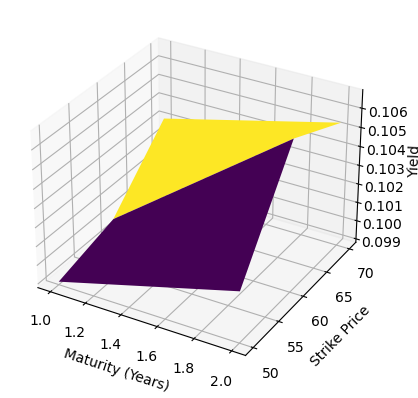

           50.0      60.0      70.0
365.0  0.098972  0.099861  0.103083
730.0  0.101514  0.106791  0.105385


In [72]:
# use MLP regression to predict the implied volatility surface from best guess parameters
# later, X and y should be applied to multiple surfaces given by monte carlo simulation or other methods
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import zscore

print(model_yield_samples)
print(real_yield_samples)

# Flatten the input and output
input_size = height * width
model_yield_samples_flattened = model_yield_samples.reshape(num_sample, input_size)
real_yield_samples_flattened = real_yield_samples.reshape(num_sample, input_size)

# normalize the input and output
model_yield_max = np.max(model_yield_samples_flattened)
real_yield_max = np.max(real_yield_samples_flattened)
model_yield_samples_flattened = model_yield_samples_flattened/model_yield_max
real_yield_samples_flattened = real_yield_samples_flattened/real_yield_max

'''
# Calculate Z-scores
z_scores_X = np.abs(zscore(X))
z_scores_y = np.abs(zscore(y))

# Define a threshold for identifying outliers
threshold = 3

# Filter out the outliers
non_outliers = (z_scores_X < threshold) & (z_scores_y < threshold)
X_filtered = X[non_outliers]
y_filtered = y[non_outliers]
'''

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(model_yield_samples_flattened, real_yield_samples_flattened, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Convert the data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

# Define the MLP regressor
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Initialize the model, loss function, and optimizer
hidden_size = 128
output_size = input_size
model = MLPRegressor(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
        
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')
    
# Predict the yield surface
with torch.no_grad():
    X_tensor = torch.FloatTensor(model_yield_samples_flattened)
    y_pred_tensor = model(X_tensor)
    y_pred = y_pred_tensor.numpy().reshape(num_sample, height, width)

# calculate the expected yield surface
y_pred = y_pred * real_yield_max
expected_yield = y_pred.mean(axis=0)
print(expected_yield.shape)
expected_yield_df = pd.DataFrame(expected_yield, index=maturities, columns=strikes)


# plot expected yield surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(maturity_years, strikes)
ax.plot_surface(X, Y, expected_yield.T, cmap='viridis')
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Yield')
plt.show()

print(expected_yield_df)

In [73]:
# store the model and export df
import pickle
new_model_filename = 'fixed_income_pricing_model.pkl'
with open(new_model_filename, 'wb') as f:
    pickle.dump(model, f)



### implement the stochastic model and mpl regression

In [74]:

# generate a new range of maturities and strikes
maturitie_test = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5] 
strikes_test = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

# implement the heston model to generate model based call values
model_price_test = np.zeros((len(maturitie_test), len(strikes_test)))
for i in range(len(maturitie_test)):
    for j in range(len(strikes_test)):
        model_price_test[i][j] = genetic_FFT(best_guess, S0, strikes_test[j], find_rf_rate(maturitie_test[i]), maturitie_test[i], alpha, eta, n, model_type)
        model_price_test[i][j] = put_to_yield(call_to_put(model_price_test[i][j], S0, strikes_test[j], find_rf_rate(maturitie_test[i]), maturitie_test[i]), find_rf_rate(maturitie_test[i]), strikes_test[j], maturitie_test[i])

model_price_test_df = pd.DataFrame(model_price_test, index=maturitie_test, columns=strikes_test)
print(model_price_test_df)

# export the expected yield surface to a excel file
#excel_file = '/Users/nannan/Nutstore Files/Nutstore/浙商资产/固定收益定价/yield_matrix.xlsx' # on my mac
excel_file = 'F:/我的坚果云/浙商资产/固定收益定价/yield_matrix.xlsx' # on my window
model_price_test_df.to_excel(excel_file, index=True)


            40        45        50        55        60        65        70  \
1.00  0.074442  0.080353  0.086380  0.092559  0.098933  0.105546  0.112451   
1.25  0.076274  0.081613  0.087025  0.092544  0.098205  0.104042  0.110094   
1.50  0.077361  0.082297  0.087274  0.092323  0.097474  0.102754  0.108192   
1.75  0.078072  0.082695  0.087336  0.092022  0.096777  0.101625  0.106589   
2.00  0.078560  0.082929  0.087295  0.091684  0.096117  0.100616  0.105199   
2.25  0.079114  0.083265  0.087397  0.091534  0.095696  0.099900  0.104165   
2.50  0.079570  0.083531  0.087460  0.091380  0.095308  0.099262  0.103255   
2.75  0.079957  0.083750  0.087501  0.091230  0.094954  0.098688  0.102447   
3.00  0.080294  0.083937  0.087528  0.091087  0.094630  0.098172  0.101725   
3.25  0.080352  0.083861  0.087310  0.090719  0.094104  0.097477  0.100849   
3.50  0.080385  0.083772  0.087092  0.090365  0.093606  0.096827  0.100040   
3.75  0.080399  0.083674  0.086877  0.090026  0.093136  0.096220

C:\Users\student\AppData\Local\Temp\ipykernel_25240\3513242136.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  x[j] = cmath.exp(-1j*beta*nu_J[j]) * discount_factor * psi_nu_J[j] * w_J


In [75]:
'''
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, height, width, num_params):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (height // 4) * (width // 4), 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_params)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Normalize the data
actual_implied_vols = implied_vol_samples / np.max(implied_vol_samples)

# Convert data to PyTorch tensors
actual_implied_vols = torch.tensor(actual_implied_vols, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
initial_heston_params = np.tile(SGD_search_params, (num_sample, 1))
initial_heston_params = torch.tensor(initial_heston_params, dtype=torch.float32)

# Split data into training and validation sets
train_vols, val_vols, train_params, val_params = train_test_split(actual_implied_vols, initial_heston_params, test_size=0.2, random_state=42)

# Define model, loss function, and optimizer
height, width = train_vols.shape[2], train_vols.shape[3]
num_params = train_params.shape[1]
model = CNNModel(height, width, num_params)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Training loop with early stopping
num_epochs = 10000
patience = 20
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_vols)
    loss = criterion(outputs, train_params)
    loss.backward()
    optimizer.step()
    
    # Calculate RMSE for training
    train_rmse = torch.sqrt(loss).item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_vols)
        val_loss = criterion(val_outputs, val_params)
        val_rmse = torch.sqrt(val_loss).item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Train RMSE: {train_rmse}, Val Loss: {val_loss.item()}, Val RMSE: {val_rmse}')
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_cnn_model.pth')
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= patience:
        print('Early stopping triggered.')
        break

# Load the best model
model.load_state_dict(torch.load('best_cnn_model.pth'))

# Evaluate the model
model.eval()
with torch.no_grad():
    calibrated_params = model(actual_implied_vols)

# Convert calibrated parameters to numpy array if needed
calibrated_params = calibrated_params.numpy()

# Print the calibrated parameters
print(calibrated_params)
'''

"\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nimport torch.nn.functional as F\n\n# Define the CNN model\nclass CNNModel(nn.Module):\n    def __init__(self, height, width, num_params):\n        super(CNNModel, self).__init__()\n        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)\n        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)\n        self.flatten = nn.Flatten()\n        self.fc1 = nn.Linear(128 * (height // 4) * (width // 4), 256)\n        self.fc2 = nn.Linear(256, 128)\n        self.fc3 = nn.Linear(128, num_params)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        x = self.pool(F.relu(self.conv3(x)))\n        x = self.flatten(x)\n        x = F.relu(self.fc1(